Classification and regression involve many specialized terms that you should get familiar with. Amongst them are:

* **Sample**: Input that goes into your model
* **Target**: What comes out of the model
* **Prediction error or loss value**: A measure of the distance between your
model’s prediction and the target.
* **Classes**: A set of possible labels or categories to choose from in a classification problem.
* **Label**: A specific instance of a class annotation in a classification problem.
* **binary classification**: The label to predict has only two possible classes
  *for example, fraud or not fraud.*
* **Multiclass classification**: The label to predict has more than two possible classes *for example, whether an image is a dog, cat, or bird*
* **Multilabel classification**: Each observation can belong to more than one class. *Movie genres are a good example of this. A movie can be classified as both action and comedy.*
* **Scalar regression**: A task where the target is a continuous scalar value.
* **Vector regression**: A task where the target is a set of continuous values.
* **Mini-batch or batch**: A small set of samples (typically between 8 and 128) that are processed simultaneously by the model.

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

The argument `num_words=10000` means you will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded which allows us to work with vector data of manageable size. If we didn’t set this limit, we would be working with 88,585 unique words in the training data, which is unnecessarily large. Many
of these words only occur in a single sample, so they cannot be meaningfully used for classification.

The variables `train_data` and `test_data` are lists of reviews. Each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

1

In [4]:
#no word index will exceed 10,000
max([max(sequence) for sequence in train_data])

9999

In [5]:
#word_index is a dictionary mapping words to an integer index.
word_index = imdb.get_word_index()
reverse_word_index = dict(
#Reverses it and mapping integer indices to words
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
#Decodes the review. Note that the indices are offset by 3
#because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

In [6]:
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

#### **Preparing the data**

We cannot directly feed lists of integers into a neural network. They all have different lengths, but a neural network expects to process contiguous batches of data. We have to turn the lists into tensors. There are two ways to do that:
1.    By padding the lists so that they all have the same length, turn them into an integer tensor of shape (`samples, max_length`), and start your model with a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in detail later in the semester).
2.   By Multi-hot encoding the lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence `[8, 5]` into a 10000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then we
can use a `Dense` layer, capable of handling floating-point vector data, as the first layer in the model.

In [7]:
'''Encoding the integer sequences via multi-hot encoding'''

import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  #Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
          #Sets specific indices of results[i] to 1s
            results[i, j] = 1.
    return results

#Vectorized training data
x_train = vectorize_sequences(train_data)
#Vectorized test data
x_test = vectorize_sequences(test_data)

In [8]:
#Here’s what the samples look like now
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

#### **Building the Model**

The input data is vectors, and the labels are scalars (1s and 0s). This is one of the simplest problem setups you will ever encounter. A type of model that performs well on such a problem is a plain stack of densely connected (`Dense`) layers with `relu` activations.

There are two key architecture decisions to be made about such a stack of Dense layers:
 * How many layers to use
 * How many units to choose for each layer

Later this semester, we will learn the principles to guide us in making these choices. For now, let's follow the following architecture.
* Two intermediate layers with 16 units each
* A third layer that will output the scalar prediction regarding the sentiment of the current review.


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

The first argument being passed to each `Dense` layer is the number of units in the layer which is the dimensionality of representation space of the layer. If you recall, each such Dense layer with a relu activation implements the following chain of tensor operations:

`output = relu(dot(input, W) + b)`

Having 16 units means the weight matrix `W` will have a shape (`input_dimension, 16`). The dot product with `W` will project the input data onto a 16-dimensional representation space, and then you will add the bias vector `b` and apply the `relu` operation.

You can intuitively understand the dimensionality of your representation space as “how much freedom you’re allowing the model to have when learning internal representations.” Having more units (a higher-dimensional representation space) allows your
model to learn more-complex representations, but it makes the model more computationally expensive and may lead to learning unwanted patterns that will
improve performance on the training data but not on the test data.

The intermediate layers use `relu` as their activation function, and the final layer uses a `sigmoid` activation so as to output a probability (a score between 0 and 1 indicating how likely the sample is to have the target “1”: how likely the review is to be positive). A `relu` (rectified linear unit) is a function meant to zero out negative values whereas a `sigmoid` “squashes” arbitrary values into the [0, 1] interval, outputting something that can be interpreted as a probability.

Finally, you need to choose a loss function and an optimizer. Because you’re facing a binary classification problem and the output of your model is a probability (you end your model with a single-unit layer with a sigmoid activation), it’s best to use the `binary_crossentropy` loss. It isn’t the only viable choice: for instance, you could use
`mean_squared_error`. But crossentropy is usually the best choice when you’re dealing with models that output probabilities.

**Crossentropy** is a quantity from the field of information theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.
 As for the choice of the optimizer, we’ll go with `rmsprop`, which is usually a good default choice for virtually any problem.

In [11]:
#This is the step where we configure the model with the rmsprop optimizer
#and the binary_crossentropy loss function

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
  #We are also monitoring the accuracy
              metrics=["accuracy"])

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train the model for 20 epochs (20 iterations over all samples in the training data) in mini-batches of 512 samples. At the same time, we will monitor loss and accuracy on the 10,000 samples that we set apart. We do so by passing the validation
data as the `validation_data` argument.

In [13]:
''' Training your model'''
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.4975 - accuracy: 0.7947 - val_loss: 0.3715 - val_accuracy: 0.8691
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2968 - accuracy: 0.9022 - val_loss: 0.2987 - val_accuracy: 0.8886
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2182 - accuracy: 0.9279 - val_loss: 0.2843 - val_accuracy: 0.8867
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1737 - accuracy: 0.9433 - val_loss: 0.2788 - val_accuracy: 0.8881
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1400 - accuracy: 0.9559 - val_loss: 0.2836 - val_accuracy: 0.8873
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1148 - accuracy: 0.9659 - val_loss: 0.2956 - val_accuracy: 0.8868
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0949 - accuracy: 0.9726 - val_loss: 0.3308 - val_accuracy: 0.8761
Epoch 8/20
30/30 [=

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The dictionary contains four entries. One per metric that was being monitored during training and during validation. In the following two listings, let’s use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy.

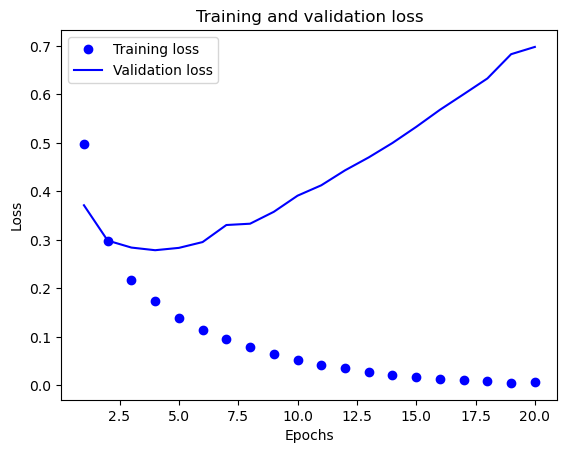

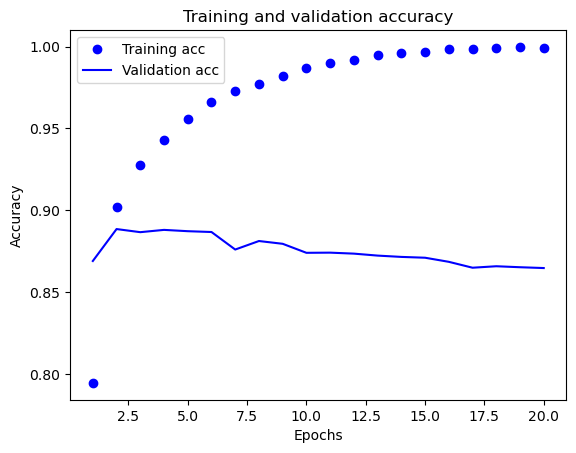

In [15]:
'''Plotting the training and validation loss'''

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

#"bo" is for blue dot.
plt.plot(epochs, loss_values, "bo", label="Training loss")

#"b" is for solid blue line.
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


''' Plotting the training and validation accuracy'''

#Clears the figure
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, while the training accuracy increases. That’s what you would expect when running gradient descent optimization. The quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier. A
model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before.

In better terms, what you’re seeing is called ***overfitting***. After the fourth epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after four epochs. In general, you can use a range of techniques to mitigate overfitting, which we’ll cover later.

In [16]:
'''Retraining a model from scratch'''

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
#limiting the epochs to 4
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 0s 4ms/step - loss: 0.4374 - accuracy: 0.8185
Epoch 2/4
49/49 [==============================] - 0s 4ms/step - loss: 0.2530 - accuracy: 0.9092
Epoch 3/4
49/49 [==============================] - 0s 4ms/step - loss: 0.1950 - accuracy: 0.9305
Epoch 4/4
782/782 [==============================] - 0s 429us/step - loss: 0.2954 - accuracy: 0.8831


In [17]:
results

[0.2953936457633972, 0.8831200003623962]

The first number, 0.29 (may slightly variate), is the test loss, and the second number, 0.88 (may slightly variate), is the test accuracy.

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

In [18]:
#using the predict method
model.predict(x_test)

782/782 [==============================] - 0s 414us/step


array([[0.1960832 ],
       [0.9996864 ],
       [0.89813066],
       ...,
       [0.13628563],
       [0.05237143],
       [0.768207  ]], dtype=float32)

As you can see, the model is confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4)

#### **Wrapping up the example**

From the above example, we can conclude the folowing:

*   You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it as tensors into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options too.
*   Stacks of `Dense` layers with `relu` activations can solve a wide range of problems including sentiment classification.
*   In a binary classification problem, your model should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your model should be a scalar between 0 and 1, encoding a probability.
*   With such a scalar sigmoid output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
*   The `rmsprop` optimizer is generally a good enough choice, whatever the problem. That’s one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.

## **Multiclass classification: Classifying Newswires**

With Binary Classification, we saw how to classify vector inputs into two mutually exclusive classes using a densely connected neural network. But what happens when we have more than two classes?

To anwer this question we will build a model to classify Reuters newswires into 46 mutually exclusive topics. Because we have many classes, this problem is an instance of **multiclass classification**, and because each data point should be classified into only one category. The problem is more specifically an instance of single-label multiclass classification.

Note that if each data point could belong to multiple categories (in this case, topics), we’d be facing a multilabel multiclass classification problem.

### **The Reuters dataset**

The Reuters dataset, a set of short newswires and their topics. It’s a simple, widely used toy dataset for text classification. There are 46 different topics. Some topics are more represented than others, but each one has at least 10 examples in the training set.
Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let’s take a look.


In [19]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

In [20]:
#number of training examples
len(train_data)


8982

In [21]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

#### **Preparing the data**

to prepare the date we can vectorize it with the exact same code as in the binary classification example by using the previously created function `vectorize_sequences`.

In [22]:
'''Encoding the input data'''

#Vectorized training data
x_train = vectorize_sequences(train_data)
#Vectorized test data
x_test = vectorize_sequences(test_data)

x_train.shape

(8982, 10000)

Now, to vectorize the labels, there are two possible way:
1.  We can cast the label list as an integer tensor.
2.  Or we can use one-hot encoding. it is a widely used format for categorical data, and is also called categorical encoding. In this case, one-hot encoding the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [23]:
'''Encoding the labels'''


def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

#Vectorized training labels
y_train = to_one_hot(train_labels)

#Vectorized test labels
y_test = to_one_hot(test_labels)

In [24]:
#BUILT IN 

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)


#### **Building your model**

Although this problem looks similar to the previous one (movie review), THe number of outputs classes are different. It has gone from 2 to 46. The dimensionality of the output space is much larger.

In a stack of Dense layers like those we’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers.
Each layer can potentially become an information bottleneck. In the Binary Classification example, we used 16-dimensional intermediate layers, but a
16-dimensional space may be too limited to categorize 46 different classes. Such small layers may act as information bottlenecks, permanently dropping relevant information.
To prevent that we will use 64 units layers.

In [25]:
'''Model definition'''

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

Two other things you should note about this architecture.
1.   We ended the model with a `Dense` layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
2.  the last layer uses a `softmax` activation which means the model will output a probability distribution over the 46 different output classes. For every input sample, the model will produce a 46-dimensional output vector, where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

In this case The best loss function to use is `categorical_crossentropy`. It measures the distance between two probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true

In [26]:
'''Compiling the model'''

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

#### **Validating your approach**

Let’s set apart 1,000 samples in the training data to use as a validation set.


In [27]:
'''Setting aside a validation set'''

x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [28]:
''' Training the model'''
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 24ms/step - loss: 2.7390 - accuracy: 0.4994 - val_loss: 1.8713 - val_accuracy: 0.6400
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 1.4774 - accuracy: 0.7105 - val_loss: 1.3467 - val_accuracy: 0.7200
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 1.0714 - accuracy: 0.7740 - val_loss: 1.1448 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.8425 - accuracy: 0.8205 - val_loss: 1.0469 - val_accuracy: 0.7800
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.6732 - accuracy: 0.8647 - val_loss: 0.9611 - val_accuracy: 0.8100
Epoch 6/20
16/16 [==============================] - 0s 10ms/step - loss: 0.5367 - accuracy: 0.8901 - val_loss: 0.9286 - val_accuracy: 0.8150
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 0.4362 - accuracy: 0.9141 - val_loss: 0.8951 - val_accuracy: 0.8210
Epoch 8/20
16/16

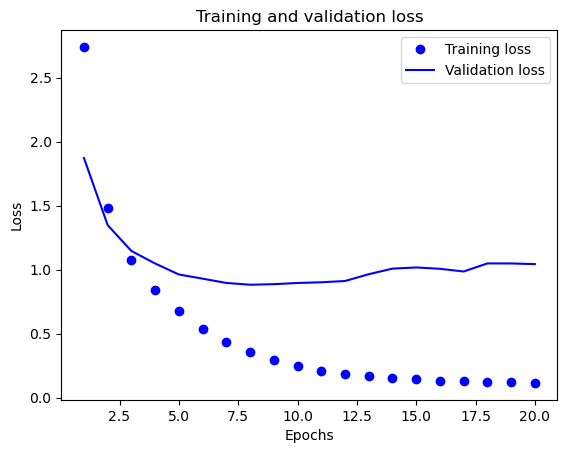

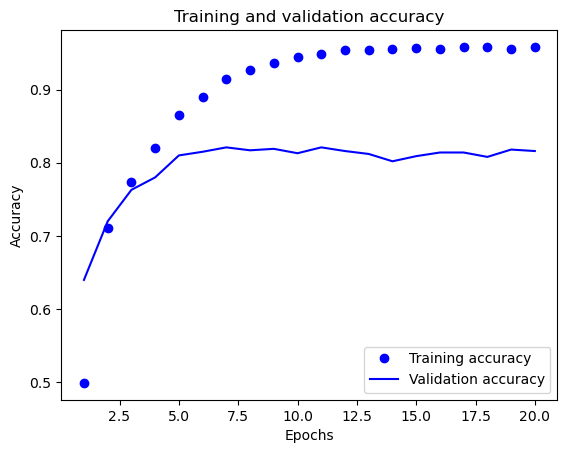

In [29]:
''' Plotting the training and validation loss'''

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


'''Plotting the training and validation accuracy'''

plt.clf() #Clears the figure
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The model begins to overfit after nine epochs. Let’s train a new model from scratch for nine epochs and then evaluate it on the test set.

In [30]:
'''Retraining a model from scratch'''
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 0s 8ms/step - loss: 2.4593 - accuracy: 0.5019
Epoch 2/9
18/18 [==============================] - 0s 8ms/step - loss: 1.3696 - accuracy: 0.7106
Epoch 3/9
18/18 [==============================] - 0s 7ms/step - loss: 1.0212 - accuracy: 0.7808
Epoch 4/9
18/18 [==============================] - 0s 8ms/step - loss: 0.8004 - accuracy: 0.8298
Epoch 5/9
18/18 [==============================] - 0s 8ms/step - loss: 0.6363 - accuracy: 0.8657
Epoch 6/9
18/18 [==============================] - 0s 8ms/step - loss: 0.5071 - accuracy: 0.8945
Epoch 7/9
18/18 [==============================] - 0s 8ms/step - loss: 0.4072 - accuracy: 0.9148
Epoch 8/9
18/18 [==============================] - 0s 9ms/step - loss: 0.3288 - accuracy: 0.9296
Epoch 9/9
71/71 [==============================] - 0s 701us/step - loss: 0.9697 - accuracy: 0.7912


In [31]:
results

[0.969720721244812, 0.7911843061447144]

This approach reaches an accuracy of approximately 80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case, we have 46 classes, and they may not be equally represented. What would be
the accuracy of a random baseline? We could try quickly implementing one to check this empirically

In [32]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()



0.18788958147818344

As you can see, a random classifier would score around 19% classification accuracy, so
the results of our model seem pretty good in that light.

#### **Generating predictions on new data**

Calling the model’s `predict` method on new samples returns a class probability distribution over all 46 topics for each sample. Let’s generate topic predictions for all of the test data

In [33]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 583us/step


In [34]:
#Each entry in “predictions” is a vector of length 46
predictions[0].shape

(46,)

In [35]:
#The coefficients in this vector sum to 1, as they form a probability distribution:
np.sum(predictions[0])

0.99999976

In [36]:
#The largest entry is the predicted class, meaning the class with the highest probability:
np.argmax(predictions[0])

3

#### **A different way to handle the labels and the loss**

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like this


In [37]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The previously used loss
function, `categorical_crossentropy`, expects the labels to follow a categorical encoding. With integer labels, you should use `sparse_categorical_crossentropy`

In [38]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

This new loss function is still mathematically the same as `categorical_crossentropy`. It just has a different interface.

#### **The importance of having sufficiently large intermediate layers**

We mentioned earlier that because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 units. Now let’s see what happens when we introduce an information bottleneck by having intermediate layers that are
significantly less than 46-dimensional. Let's try with 4 dimensional.

In [39]:
'''A model with an information bottleneck'''

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 0s 5ms/step - loss: 2.9162 - accuracy: 0.2081 - val_loss: 2.2851 - val_accuracy: 0.3620
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 1.8478 - accuracy: 0.5695 - val_loss: 1.6049 - val_accuracy: 0.6160
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 1.3839 - accuracy: 0.6551 - val_loss: 1.4211 - val_accuracy: 0.6490
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 1.2039 - accuracy: 0.6958 - val_loss: 1.3560 - val_accuracy: 0.6800
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 1.0853 - accuracy: 0.7254 - val_loss: 1.3327 - val_accuracy: 0.6880
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.9860 - accuracy: 0.7539 - val_loss: 1.3427 - val_accuracy: 0.6950
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.8995 - accuracy: 0.7700 - val_loss: 1.3538 - val_accuracy: 0.7010
Epoch 8/20
63/63 [==

The model now peaks at approximately 71% validation accuracy, an 8% absolute drop. This drop is mostly due to the fact that we’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The model is able to cram most of the necessary information into these four-dimensional representations, but not all of it.

#### Wrapping up the example

From the above example, we have learned that:
*    If we’re trying to classify data points among N classes, our model should end with a Dense layer of size N
*    In a single-label, multiclass classification problem, your model should end with a `softmax` activation so that it will output a probability distribution over the N output classes.
*    Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.
*    There are two ways to handle labels in multiclass classification:
    *    Encoding the labels via categorical encoding (also known as one-hot encoding) and using `categorical_crossentropy` as a loss function
    *    Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function
*    If we need to classify data into a large number of categories, we should avoid creating information bottlenecks in our model due to intermediate layers that are too small.